In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [32]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [26]:
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 14

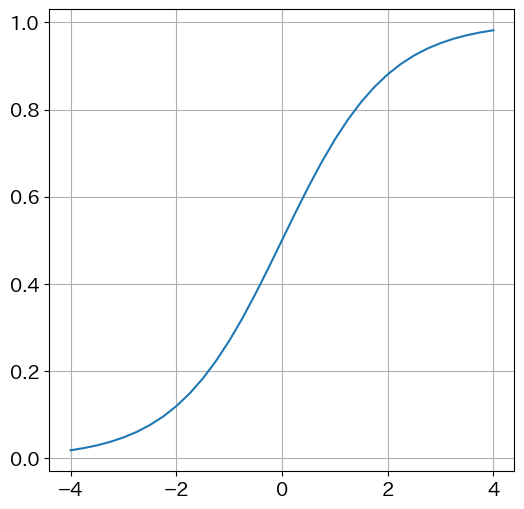

In [27]:
x = np.arange(-4, 4.1, 0.25)
x = torch.tensor(x).float()

y = torch.sigmoid(x)

plt.plot(x.data, y.data)


In [16]:
x.dtype

torch.float32

In [35]:
# データの準備

iris = load_iris()
x_org, y_org = iris.data, iris.target

# 二値分類用にデータの絞り込み,特徴量も２つにする
x_data = iris.data[:100, :2]
y_data = iris.target[:100]


# 訓練データ、検証データに分割
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=123)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70, 2) (30, 2) (70,) (30,)


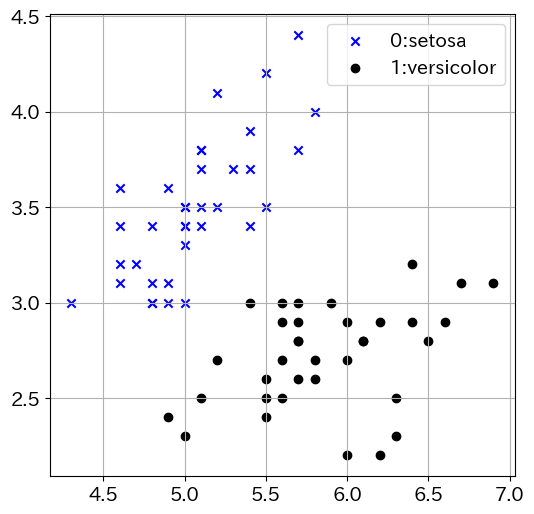

In [42]:
# データの描画
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x', c='b', label='0:setosa')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o', c='k', label='1:versicolor')
plt.legend()

## モデル定義

In [90]:
n_input = x_train.shape[1]
n_output = 1

# モデルの定義
class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()


        # 初期化
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)


    #順伝播
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        return x2

# 損失関数のインスタンス
criterion = nn.BCELoss()

# 学習率
lr = 0.01

# 最適化関数のインスタンス
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し
num_epochs = 10000

# 記録リスト[epoch数, 訓練データの損失, 訓練データの精度, 検証データの損失, 検証データの精度]
history = np.zeros((0, 5))

In [56]:
# インスタンス生成
net = Net(n_input, n_output)

print(net)
print('\n')

for param in net.named_parameters():
    print(param)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


('l1.weight', Parameter containing:
tensor([[1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1.], requires_grad=True))


In [65]:
# summary
summary(net, x_train.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [70, 1]                   --
├─Linear: 1-1                            [70, 1]                   3
├─Sigmoid: 1-2                           [70, 1]                   --
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [74]:
# データのテンソル化

# 学習データ
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

# 検証データ
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()


# labelを2次元に変換
label1 = labels.view(-1, 1)
label1_test = labels_test.view(-1, 1)


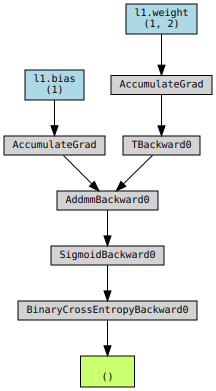

In [82]:
# 計算グラフ
outputs = net(inputs)
loss = criterion(outputs, label1)
make_dot(loss, dict(net.named_parameters()))

In [91]:
# モデルの実行

for epoch in range(num_epochs):

    # gradの初期化
    optimizer.zero_grad()

    #　順伝播
    outputs = net(inputs)
    loss = criterion(outputs, label1)

    #　勾配計算
    loss.backward()

    # パラメータの更新
    optimizer.step()

    # 損失の保存
    train_loss = loss.item()

    # 推論
    predict = torch.where(outputs < 0.5, 0, 1)

    #　精度計算
    train_acc = (predict == label1).sum() / len(y_train)


    #=== test ====
    output_test = net(inputs_test)
    loss_test = criterion(output_test, label1_test)
    val_loss = loss_test.item()
    
    predict_test = torch.where(output_test < 0.5, 0, 1)
    val_acc = (predict_test == label1_test).sum() / len(y_test)


    # 記録の表示や保存
    if epoch % 10 == 0:
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.57935 acc: 0.50000 val_loss: 4.30802, val_acc: 0.50000
Epoch [10/10000], loss: 3.61228 acc: 0.50000 val_loss: 3.38007, val_acc: 0.50000
Epoch [20/10000], loss: 2.65300 acc: 0.50000 val_loss: 2.46143, val_acc: 0.50000
Epoch [30/10000], loss: 1.74405 acc: 0.50000 val_loss: 1.60170, val_acc: 0.50000
Epoch [40/10000], loss: 1.07003 acc: 0.50000 val_loss: 0.99948, val_acc: 0.50000
Epoch [50/10000], loss: 0.81642 acc: 0.50000 val_loss: 0.80090, val_acc: 0.50000
Epoch [60/10000], loss: 0.76604 acc: 0.50000 val_loss: 0.76805, val_acc: 0.46667
Epoch [70/10000], loss: 0.75248 acc: 0.30000 val_loss: 0.75970, val_acc: 0.26667
Epoch [80/10000], loss: 0.74377 acc: 0.25714 val_loss: 0.75315, val_acc: 0.20000
Epoch [90/10000], loss: 0.73575 acc: 0.24286 val_loss: 0.74642, val_acc: 0.16667
Epoch [100/10000], loss: 0.72794 acc: 0.25714 val_loss: 0.73962, val_acc: 0.16667
Epoch [110/10000], loss: 0.72027 acc: 0.27143 val_loss: 0.73284, val_acc: 0.20000
Epoch [120/10000], loss: 0.

In [94]:
net.

OrderedDict([('l1.weight', tensor([[ 2.9703, -5.3004]])),
             ('l1.bias', tensor([0.3386]))])

In [95]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 4.30802 精度: 0.50000
最終状態: 損失: 0.15394 精度: 0.96667


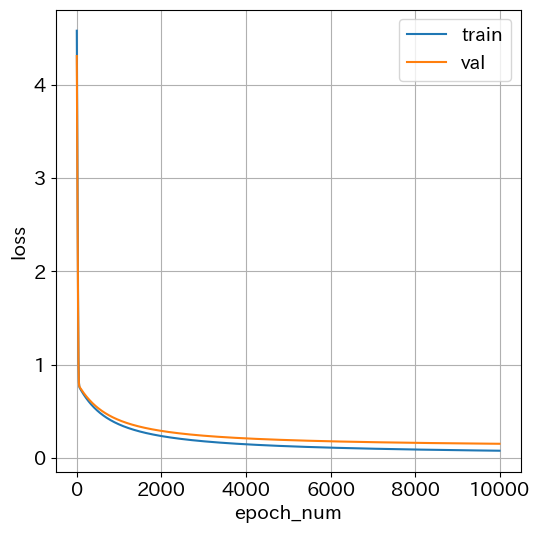

In [97]:
# 学習曲線
plt.plot(history[:, 0], history[:, 1], label='train')
plt.plot(history[:, 0], history[:, 3], label='val')
plt.xlabel('epoch_num')
plt.ylabel('loss')
plt.legend()

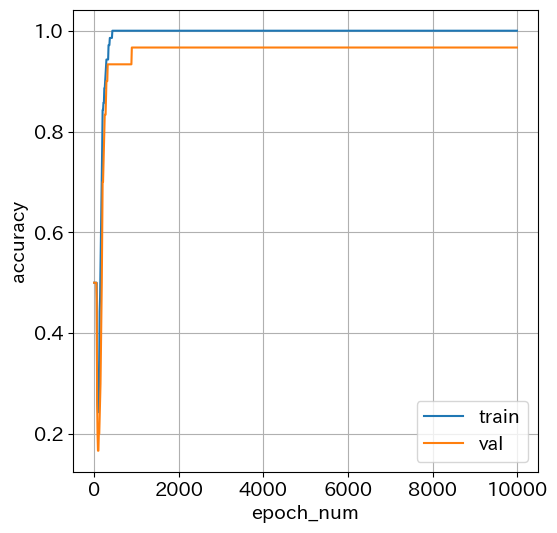

In [98]:
# 学習曲線(acc)
plt.plot(history[:, 0], history[:, 2], label='train')
plt.plot(history[:, 0], history[:, 4], label='val')
plt.xlabel('epoch_num')
plt.ylabel('accuracy')
plt.legend()

In [104]:
#　決定境界

weight = net.l1.weight.data
bias = net.l1.bias.data

# x1をxに代入してx2を求める式
def decision(x):
    return -(bias + weight[0, 0]*x)/weight[0,1]

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

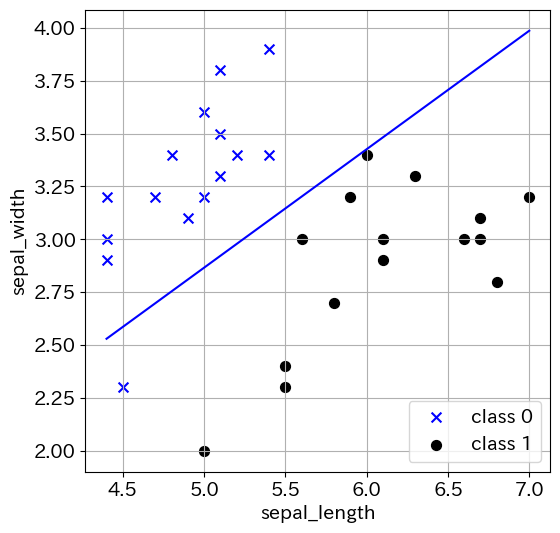

In [107]:
# 散布図表示
x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()